### Import Libraries

In [1]:
#import flwr libraries
import flwr as fl
from flwr.common import (
    ndarrays_to_parameters,
)
from flwr.client import Client, ClientApp
from flwr.simulation import run_simulation
from flwr.server import ServerApp, ServerConfig, ServerAppComponents

from typing import Dict, List

import tensorflow as tf
import numpy as np
import os
import random
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from resnet_model import build_ResNet
from FlowerClient import *
from get_client import *
from FlowerServer import *
from load_dataset import load_dataset, splitting_dataset
from utils import build_results_schema, write_instance_on_results

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2025-03-11 23:27:23,211	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


2.16.2


In [2]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.16.2
Num GPUs Available: 1


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load Dataset

In [3]:
train_dataset_path = "./Datasets/Datasets_Training/StarLightsCurves/StarLightCurves_TRAIN.txt"
test_dataset_path = "./Datasets/Datasets_Training/StarLightsCurves/StarLightCurves_TEST.txt"

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(train_dataset_path, test_dataset_path)

(900, 1024, 1) (900,) (100, 1024, 1) (100,) (8236, 1024, 1) (8236,)


### Dataset Split and Graphical Distribution

[0, 90, 180, 270, 360, 450, 540, 630, 720, 810, 900]
[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


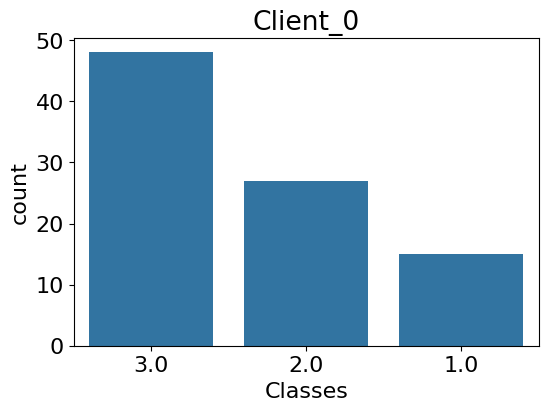

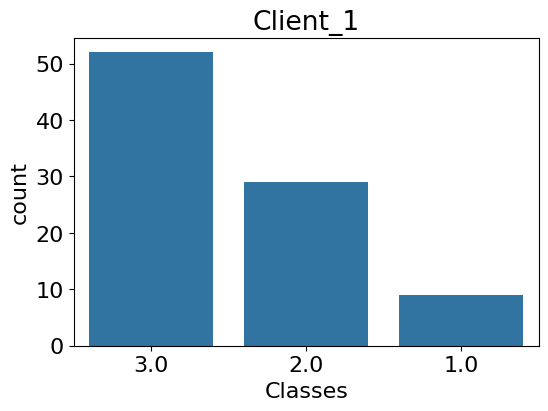

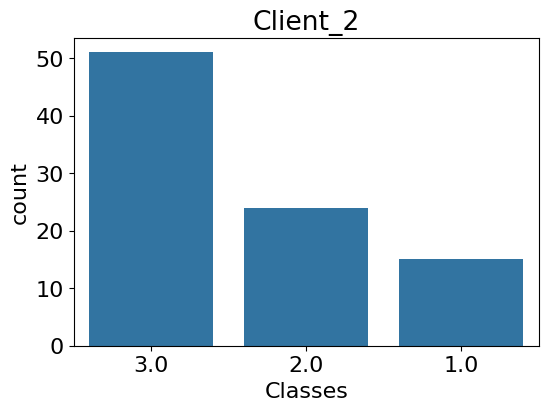

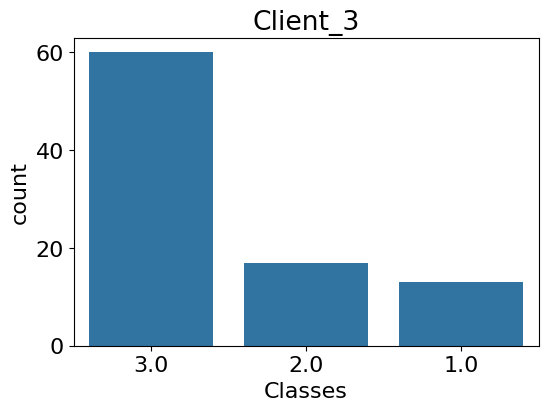

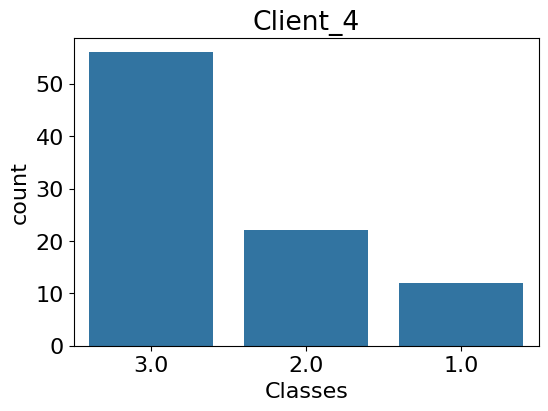

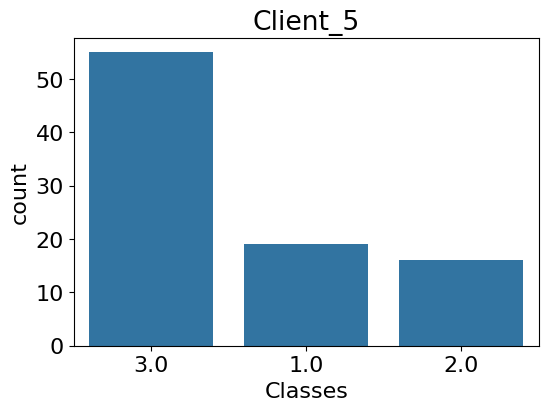

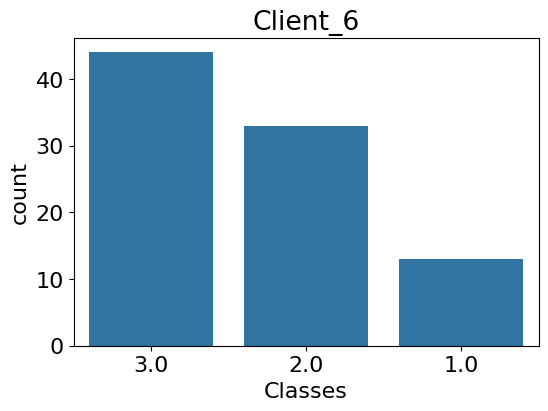

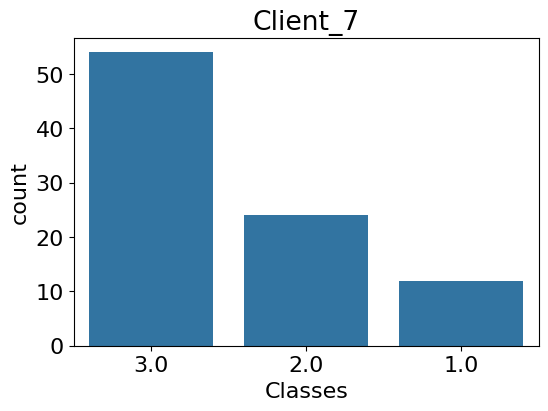

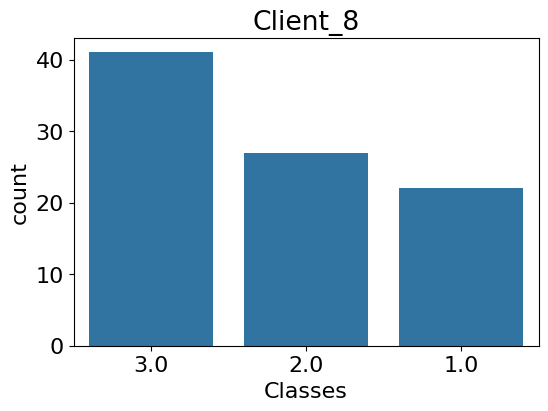

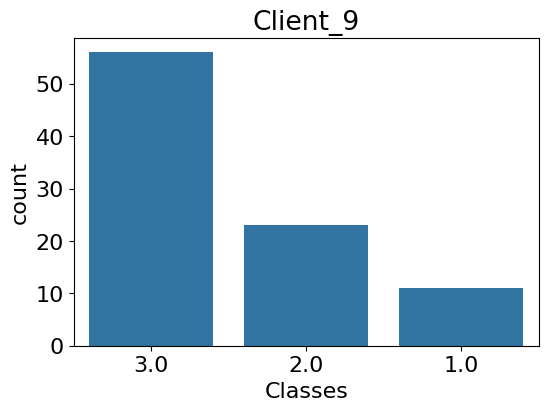

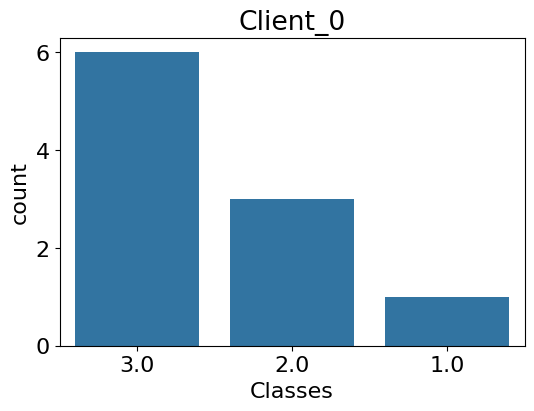

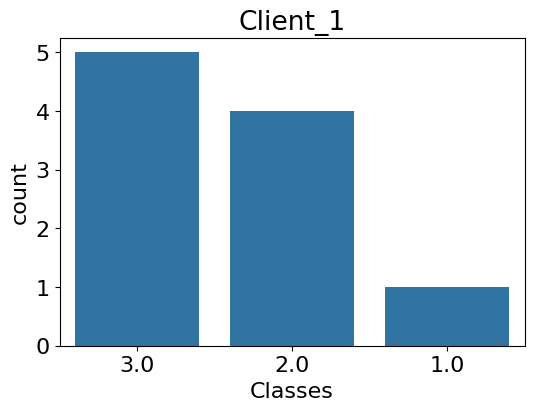

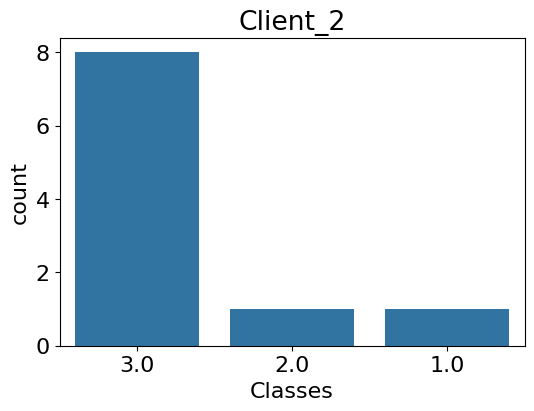

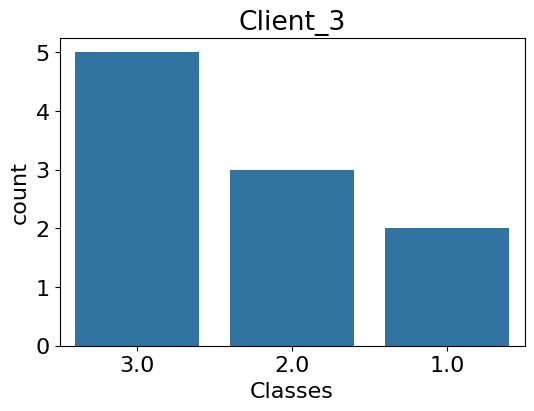

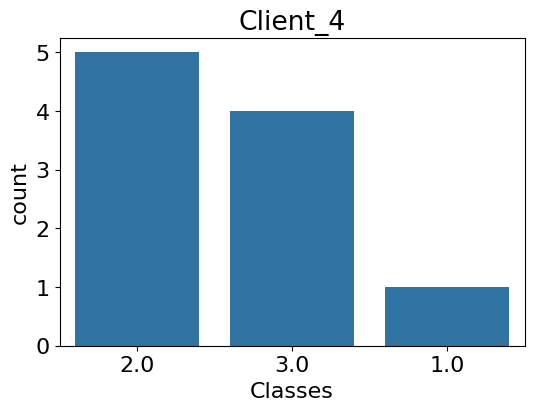

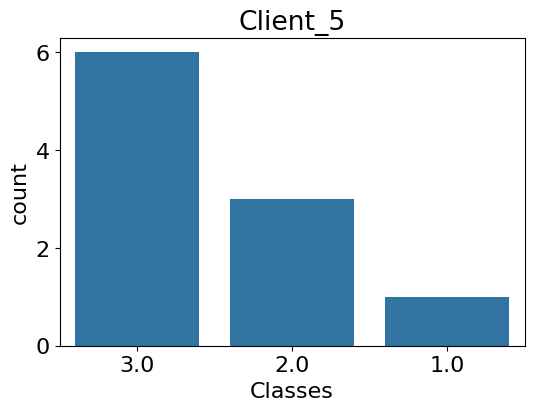

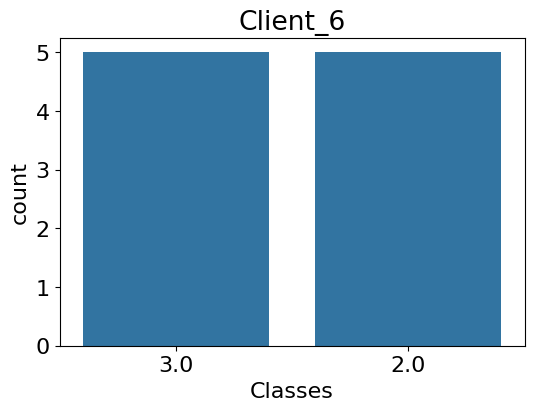

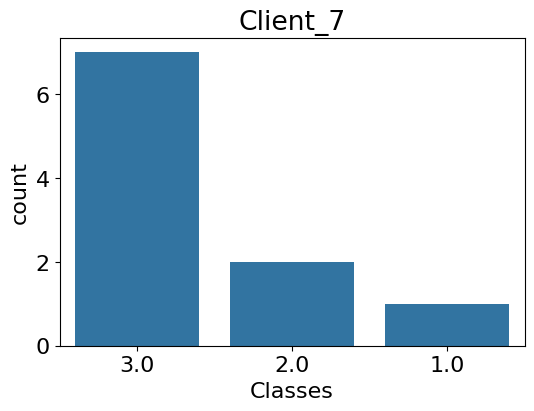

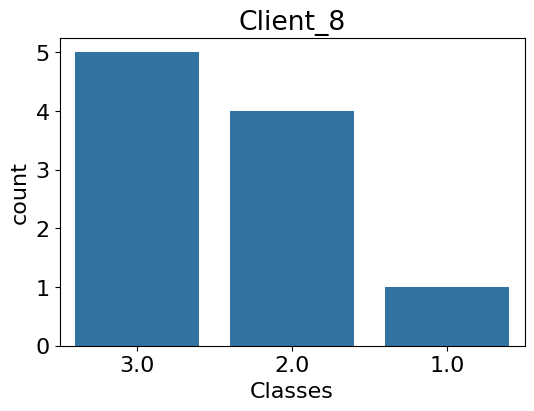

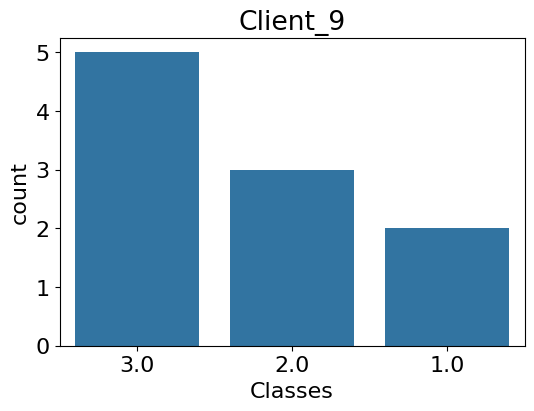

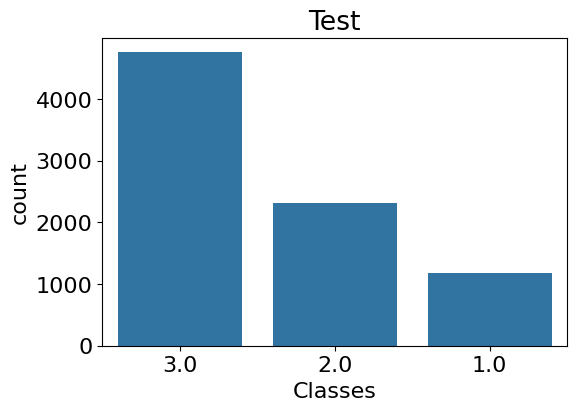

In [4]:
#Dataset Split and Graphica distribution
column_name = ["Classes"]
clients = 10
indexes_train = splitting_dataset(dataset=X_train, num_clients=clients)
print(indexes_train)
indexes_val = splitting_dataset(dataset=X_val, num_clients=clients)
print(indexes_val)


for i in range(0,clients):
  start_index = indexes_train[i]
  end_index = indexes_train[i + 1]
  df = pd.DataFrame(y_train[start_index:end_index])
  df.columns = column_name

  # Inspect activities timestamps
  plt.figure(figsize=(6,4))
  sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
  plt.title(f'Client_{i}')
  plt.show()

for i in range(0,clients):
  start_index = indexes_val[i]
  end_index = indexes_val[i + 1]
  df = pd.DataFrame(y_val[start_index:end_index])
  df.columns = column_name

  # Inspect activities timestamps
  plt.figure(figsize=(6,4))
  sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
  plt.title(f'Client_{i}')
  plt.show()

  df = pd.DataFrame(y_test)
  df.columns = column_name

# Inspect activities timestamps
plt.figure(figsize=(6,4))
sns.countplot(x = 'Classes', data = df, order = df.Classes.value_counts().index)
plt.title(f'Test')
plt.show()

### Load Parameters and Dataset split

In [5]:
# Convert the sparse labels to categorical values, y_train will be converted after data poisoning
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

input_shape = X_train.shape[1:]
classes = tfk.utils.to_categorical(y_train).shape[-1]

### Simulation

In [ ]:
NUM_CLIENTS = 10 #Number of clients available
FRACTION_FIT = 0.2 #Fraction of clients considered for training during each round
NUM_SET_CLIENTS = 10 #Only for a vertical configuration where only a subset of all the clients are considered available for training
DATA_VOLUME = 1.0
DATA_QUALITY_DIMENSION = 'consistency'
VALUE = 1.0
EXPERIMENT_TYPE = 'fixed' 
# Results saved in the same json file until it changes to track the same experiment
file_path = f"./Datasets/Datasets_Training/StarLightsCurves/results/new_results.json"

#Parameters for vertical and mixed reduction configurations (nodes and data volume) 
'''
OFFSET = 0.1
num_clients = int(NUM_CLIENTS * FRACTION_FIT)
number_clients_considered = (int)(NUM_CLIENTS * FRACTION_FIT)
volume_data = num_clients * 0.1 #0.125 is the base fraction of dataset per each client
#If we consider Vertical ClientConfigurationStrategy 
vertical_quality = (float)(OFFSET * (number_clients_considered - (int)(ACCURACY * (number_clients_considered)))) + ACCURACY
'''

result_schema = build_results_schema(
    experiment_type=EXPERIMENT_TYPE,
    num_clients_available=NUM_CLIENTS,
    num_clients_trained=int(NUM_CLIENTS * FRACTION_FIT),
    data_volume_per_client=DATA_VOLUME,
    poisoning_type=DATA_QUALITY_DIMENSION,
    data_quality_value=VALUE
)

write_instance_on_results(file_path=file_path, result_schema=result_schema)

new_model = build_ResNet(input_shape, classes)

2025-03-09 09:36:11.286494: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-09 09:36:11.286509: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


keras.src.models.functional.Functional

In [10]:
# Create strategy | add which strategies you want to test from ClientConfigurationStrategies
strategy_basic = FedCustom(
    file_path=file_path,
    model=new_model,
    x_test=X_test,
    y_test=y_test,
    n_rounds=3,
    experiment_type=EXPERIMENT_TYPE,
    fraction_fit=FRACTION_FIT,
    fraction_evaluate=0.1,
    min_fit_clients=1,
    min_evaluate_clients=1,
    min_available_clients=NUM_CLIENTS,
    initial_parameters=ndarrays_to_parameters(new_model.get_weights()),
)

def server_fn(context: Context) -> ServerAppComponents:
    # Configure the server for just 3 rounds of training
    config = ServerConfig(num_rounds=3)
    return ServerAppComponents(
        config=config,
        strategy=strategy_basic,  # <-- pass the new strategy here
    )

# Create the ServerApp and ClientApp
server = ServerApp(server_fn=server_fn)
client = ClientApp(client_fn=get_client_fn_simulation(DATA_QUALITY_DIMENSION, X_train, y_train, X_val, y_val, indexes_train, indexes_val, DATA_VOLUME, VALUE))

In [ ]:
# Run simulation
backend_config = {"client_resources": {"num_cpus": 14}}

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout


INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
2025-03-09 09:36:11.745081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


258/258 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.2746 - loss: 1.3557


INFO :      initial parameters (loss, other metrics): 1.3554236888885498, {'accuracy': 0.27986887097358704}
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 10)


Round 1 will sample clients: [2776937625713491339, 15167698965877132805]


(ClientAppActor pid=24332) 2025-03-09 09:36:16.567556: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
(ClientAppActor pid=24332) 2025-03-09 09:36:16.567590: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
(ClientAppActor pid=24332) 2025-03-09 09:36:16.567599: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
(ClientAppActor pid=24332) 2025-03-09 09:36:16.567614: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
(ClientAppActor pid=24332) 2025-03-09 09:36:16.567635: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


(ClientAppActor pid=24332) Client with CID: 0
(ClientAppActor pid=24332) 
(ClientAppActor pid=24332) Starting Fit


(ClientAppActor pid=24332) [codecarbon INFO @ 09:36:16] offline tracker init
(ClientAppActor pid=24332) [codecarbon WARNING @ 09:36:16] Multiple instances of codecarbon are allowed to run at the same time.
(ClientAppActor pid=24332) [codecarbon WARNING @ 09:36:16] No CPU tracking mode found. Falling back on CPU constant mode. 
(ClientAppActor pid=24332)  Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU
(ClientAppActor pid=24332) 


(ClientAppActor pid=24332) The batch_size is 9
(ClientAppActor pid=24332) The epochs are 40
(ClientAppActor pid=24332) (90, 4)


(ClientAppActor pid=24332) [codecarbon WARNING @ 09:36:17] We saw that you have a Apple M4 Pro but we don't know it. Please contact us.


(ClientAppActor pid=24332) Epoch 1/40


(ClientAppActor pid=24332) 2025-03-09 09:36:17.962981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


2/9 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7222 - loss: 0.8247
4/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7477 - loss: 0.7302
8/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7692 - loss: 0.6570
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - accuracy: 0.7709 - loss: 0.6359 - val_accuracy: 0.8889 - val_loss: 1.1844 - learning_rate: 0.0010
(ClientAppActor pid=24332) Epoch 2/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7778 - loss: 0.4036
3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8086 - loss: 0.3848
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8294 - loss: 0.3863
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8236 - loss: 0.4099
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8227 - loss: 0.4168 - val_accuracy: 0.8889 - val_loss: 1.0656 - learning_rate: 0.0010
(ClientAppActor pid=24332) Epoch 3/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8889 - loss: 0.3411
3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9012 - loss: 0.3333


(ClientAppActor pid=24332) [codecarbon WARNING @ 09:36:32] Multiple instances of codecarbon are allowed to run at the same time.


(ClientAppActor pid=24332) Starting Fit
(ClientAppActor pid=24332) The batch_size is 9
(ClientAppActor pid=24332) The epochs are 40
(ClientAppActor pid=24332) (90, 4)


(ClientAppActor pid=24332) [codecarbon WARNING @ 09:36:33] No CPU tracking mode found. Falling back on CPU constant mode. 
(ClientAppActor pid=24332)  Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU
(ClientAppActor pid=24332) 
(ClientAppActor pid=24332) [codecarbon WARNING @ 09:36:33] We saw that you have a Apple M4 Pro but we don't know it. Please contact us.


(ClientAppActor pid=24332) Epoch 1/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step - accuracy: 0.5556 - loss: 1.1593
3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6296 - loss: 0.9845
5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6778 - loss: 0.8570
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7041 - loss: 0.8010
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7234 - loss: 0.7601
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.7300 - loss: 0.7452 - val_accuracy: 0.3333 - val_loss: 1.2635 - learning_rate: 0.0010
(ClientAppActor pid=24332) Epoch 2/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.3000
5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9122 - loss: 0.3575
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9029 - loss: 0.3615
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.8833 - loss: 0.4017 - val_accuracy: 0.7778 - val_loss: 1.0275 - learning_rate: 0.0010
(ClientAppActor pid=24332) Epoch 3/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/st

INFO :      aggregate_fit: received 2 results and 0 failures


7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8426 - loss: 0.2985
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8565 - loss: 0.2912 - val_accuracy: 0.2222 - val_loss: 2.5859 - learning_rate: 5.0000e-04
(ClientAppActor pid=24332) {'effective_epochs': 29, 'effective_emissions_kg': 6.443565612596602e-05, 'effective_energy_consumed': 0.000194835648879, 'effective_duration': 16.632519960403442}
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7751 - loss: 1.0619


INFO :      fit progress: (1, 1.0622752904891968, {'accuracy': 0.7752549648284912}, 36.68403258299804)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 10)


(ClientAppActor pid=24332) Client with CID: 5
(ClientAppActor pid=24332) 
(ClientAppActor pid=24332) [Client 5] evaluation


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 2 clients (out of 10)
(ClientAppActor pid=24332) [codecarbon WARNING @ 09:36:53] Multiple instances of codecarbon are allowed to run at the same time.


Round 2 will resample clients: [2776937625713491339, 15167698965877132805]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9000 - loss: 1.0236
(ClientAppActor pid=24332) Client with CID: 0
(ClientAppActor pid=24332) 
(ClientAppActor pid=24332) Starting Fit
(ClientAppActor pid=24332) The batch_size is 9
(ClientAppActor pid=24332) The epochs are 40
(ClientAppActor pid=24332) 
(ClientAppActor pid=24332) (90, 4)


(ClientAppActor pid=24332) [codecarbon WARNING @ 09:36:54] No CPU tracking mode found. Falling back on CPU constant mode. 
(ClientAppActor pid=24332)  Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU
(ClientAppActor pid=24332) 
(ClientAppActor pid=24332) [codecarbon WARNING @ 09:36:54] We saw that you have a Apple M4 Pro but we don't know it. Please contact us.


(ClientAppActor pid=24332) Epoch 1/40
3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8889 - loss: 0.3058
5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8700 - loss: 0.3216
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8410 - loss: 0.3484
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8268 - loss: 0.3628
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.8231 - loss: 0.3670 - val_accuracy: 0.8889 - val_loss: 0.7524 - learning_rate: 0.0010
(ClientAppActor pid=24332) Epoch 2/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8889 - loss: 0.2900
3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8457 - loss: 0.3140
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8333 - loss: 0.3280
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8371 - loss: 0.3271
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8373 - loss: 0.3276 - val_accuracy: 0.8889 - val_loss: 0.5894 - learning_rate: 0.0010
(ClientAppActor pid=24332) Epoch 3/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/s

(ClientAppActor pid=24332) [codecarbon WARNING @ 09:37:09] Multiple instances of codecarbon are allowed to run at the same time.
(ClientAppActor pid=24332) [codecarbon WARNING @ 09:37:10] No CPU tracking mode found. Falling back on CPU constant mode. 
(ClientAppActor pid=24332)  Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU
(ClientAppActor pid=24332) 
(ClientAppActor pid=24332) [codecarbon WARNING @ 09:37:10] We saw that you have a Apple M4 Pro but we don't know it. Please contact us.


(ClientAppActor pid=24332) Epoch 1/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.8889 - loss: 0.2401
3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8580 - loss: 0.3391
5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8504 - loss: 0.3534
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8565 - loss: 0.3486
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8609 - loss: 0.3494
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.8613 - loss: 0.3545 - val_accuracy: 0.7778 - val_loss: 0.9647 - learning_rate: 0.0010
(ClientAppActor pid=24332) Epoch 2/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8889 - loss: 0.4249
3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8272 - loss: 0.4955
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8182 - loss: 0.4539
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8238 - loss: 0.4358
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8253 - loss: 0.4305 - val_accuracy: 0.7778 - val_loss: 0.7423 - learning_rate: 0.0010
(

INFO :      aggregate_fit: received 2 results and 0 failures


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9233 - loss: 0.1611
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9199 - loss: 0.1643 - val_accuracy: 0.2222 - val_loss: 1.4153 - learning_rate: 5.0000e-04
(ClientAppActor pid=24332) {'effective_epochs': 28, 'effective_emissions_kg': 6.509466247352977e-05, 'effective_energy_consumed': 0.0001968283022802, 'effective_duration': 16.789793014526367}
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7372 - loss: 0.7275


INFO :      fit progress: (2, 0.728386640548706, {'accuracy': 0.7376153469085693}, 73.88693624999723)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 10)


(ClientAppActor pid=24332) Client with CID: 9
(ClientAppActor pid=24332) 
(ClientAppActor pid=24332) [Client 9] evaluation


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 10)


Round 3 will resample clients: [2776937625713491339, 15167698965877132805]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.7000 - loss: 0.7758
(ClientAppActor pid=24332) Client with CID: 0
(ClientAppActor pid=24332) 
(ClientAppActor pid=24332) Starting Fit


(ClientAppActor pid=24332) [codecarbon WARNING @ 09:37:30] Multiple instances of codecarbon are allowed to run at the same time.


(ClientAppActor pid=24332) The batch_size is 9
(ClientAppActor pid=24332) The epochs are 40
(ClientAppActor pid=24332) (90, 4)


(ClientAppActor pid=24332) [codecarbon WARNING @ 09:37:31] No CPU tracking mode found. Falling back on CPU constant mode. 
(ClientAppActor pid=24332)  Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU
(ClientAppActor pid=24332) 
(ClientAppActor pid=24332) [codecarbon WARNING @ 09:37:31] We saw that you have a Apple M4 Pro but we don't know it. Please contact us.


(ClientAppActor pid=24332) Epoch 1/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.8889 - loss: 0.2879
3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8148 - loss: 0.3932
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7954 - loss: 0.4183
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7973 - loss: 0.4129
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.7978 - loss: 0.4107 - val_accuracy: 0.8889 - val_loss: 0.6932 - learning_rate: 0.0010
(ClientAppActor pid=24332) Epoch 2/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6667 - loss: 0.5893
5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7674 - loss: 0.4715
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7681 - loss: 0.4748
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7696 - loss: 0.4707 - val_accuracy: 0.8889 - val_loss: 0.7177 - learning_rate: 0.0010
(ClientAppActor pid=24332) Epoch 3/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.1367
3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/st

(ClientAppActor pid=24332) [codecarbon WARNING @ 09:37:48] Multiple instances of codecarbon are allowed to run at the same time.
(ClientAppActor pid=24332) [codecarbon WARNING @ 09:37:48] No CPU tracking mode found. Falling back on CPU constant mode. 
(ClientAppActor pid=24332)  Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU
(ClientAppActor pid=24332) 
(ClientAppActor pid=24332) [codecarbon WARNING @ 09:37:48] We saw that you have a Apple M4 Pro but we don't know it. Please contact us.


(ClientAppActor pid=24332) Epoch 1/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.8889 - loss: 0.2299
3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.8765 - loss: 0.3254
5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8770 - loss: 0.3466
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8566 - loss: 0.3758
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - accuracy: 0.8536 - loss: 0.3797 - val_accuracy: 0.6667 - val_loss: 0.6600 - learning_rate: 0.0010
(ClientAppActor pid=24332) Epoch 2/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 1.0000 - loss: 0.1311
5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9407 - loss: 0.2284
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9286 - loss: 0.2465
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.9103 - loss: 0.2686 - val_accuracy: 0.7778 - val_loss: 0.5766 - learning_rate: 0.0010
(ClientAppActor pid=24332) Epoch 3/40
1/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 1.0000 - loss: 0.1955
5/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/st

INFO :      aggregate_fit: received 2 results and 0 failures


7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9555 - loss: 0.1957
Final records: {'effective_epochs': 171, 'effective_emissions_kg': 0.0003807950994762366, 'effective_energy_consumed': 0.0011514193345271, 'effective_duration': 98.11426615715027}
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9495 - loss: 0.1902 - val_accuracy: 0.6667 - val_loss: 0.6157 - learning_rate: 5.0000e-04
(ClientAppActor pid=24332) {'effective_epochs': 27, 'effective_emissions_kg': 6.0437927491788725e-05, 'effective_energy_consumed': 0.0001827476203042, 'effective_duration': 15.61113715171814}
258/258 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8427 - loss: 0.6034


INFO :      fit progress: (3, 0.599384605884552, {'accuracy': 0.84288489818573}, 111.1512942920017)
INFO :      configure_evaluate: strategy sampled 1 clients (out of 10)


(ClientAppActor pid=24332) Client with CID: 6
(ClientAppActor pid=24332) 
(ClientAppActor pid=24332) [Client 6] evaluation


INFO :      aggregate_evaluate: received 1 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 3 round(s) in 111.88s
INFO :      	History (loss, distributed):
INFO :      		round 1: 1.0235711336135864
INFO :      		round 2: 0.775765061378479
INFO :      		round 3: 0.35353580117225647
INFO :      	History (loss, centralized):
INFO :      		round 0: 1.3554236888885498
INFO :      		round 1: 1.0622752904891968
INFO :      		round 2: 0.728386640548706
INFO :      		round 3: 0.599384605884552
INFO :      	History (metrics, centralized):
INFO :      	{'accuracy': [(0, 0.27986887097358704),
INFO :      	              (1, 0.7752549648284912),
INFO :      	              (2, 0.7376153469085693),
INFO :      	              (3, 0.84288489818573)]}
INFO :      


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 1.0000 - loss: 0.3535
